# Overview

VLA 22A-020 observed NaCl and KCl transitions toward Sgr B2 in the K band.

PRIMOS detected NaCl 2-1 ?emission or absorption? (in 5 hyperfine transitions) at 26.01 GHz at T$_A^*\sim0.05$ K.  The GBT beam at 26 GHz is ~30"

In [1]:
import numpy as np
from astropy import units as u

In [2]:
from spectral_cube import SpectralCube

In [3]:
nacl21rest = 26.0518979*u.GHz

In [4]:
gbtbeam = (1.22 * nacl21rest.to(u.m, u.spectral()) / (100*u.m)).to(u.arcsec, u.dimensionless_angles())
gbtbeamarea = (2*np.pi*(gbtbeam/2.35)**2)
gbtbeam

<Quantity 28.95784901 arcsec>

This gives a flux density:

In [5]:
(0.05*u.K ).to(u.Jy, u.brightness_temperature(frequency=nacl21rest, beam_area=gbtbeamarea))

<Quantity 0.02338014 Jy>

The observations achieved a beam size about 0.4"x0.2" with robust=2:

In [6]:
cd ../imaging_Darray/

/orange/adamginsburg/sgrb2/22A-020/imaging_Darray


In [7]:
cube = SpectralCube.read('KbandDarray.center.robust0.spw13.big-coarse.liteclean.image')
vlabeam = cube.beams.common_beam()
vlabeam

/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


Beam: BMAJ=5.019992947832322 arcsec BMIN=2.0791804341136486 arcsec BPA=-15.371535693486829 deg

If the emission were concentrated into a single beam, then the peak brightness would be:

In [8]:
0.05*u.K * (gbtbeamarea/vlabeam.sr).decompose()

<Quantity 4.03354624 K>

The typical uncertainty achieved in our data is:

In [9]:
uncertainty = cube.std()
uncertainty

<Quantity 0.07953199 Jy / beam>

In [10]:
uncertainty.to(u.K, u.brightness_temperature(nacl21rest, beam_area=vlabeam))

<Quantity 13.72087479 K>

This is per channel with width:

In [11]:
cube.with_spectral_unit(u.km/u.s, rest_value=nacl21rest, velocity_convention='radio').spectral_axis.diff().mean()

<Quantity -0.35961704 km / s>

### listobs:  

https://data.rc.ufl.edu/secure/adamginsburg/SgrB2/22A-020/22A-020_sb41854998_1_1.59785.110016307866/pipeline-20220726T015648/html/t2-1.html?sidebar=sidebar_22A_020_sb41854998_1_1_59785_110016307866_ms&subpage=listobs.txt


In [12]:
pth = '/orange/adamginsburg/sgrb2/22A-020/imaging_Darray/KbandDarray.center.robust0.spw13.big-coarse.liteclean.image'

if not os.path.exists(pth+".contsub.fits"):
    naclcube = SpectralCube.read(pth).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nacl21rest)
    cont = naclcube.median(axis=0)
    contsub = naclcube - cont
    contsub.write(pth+".contsub.fits")
naclcube = SpectralCube.read(pth+".contsub.fits", use_dask=True).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nacl21rest)
naclcube

DaskVaryingResolutionSpectralCube with shape=(1024, 500, 500) and unit=Jy / beam and chunk size (322, 322, 322):
 n_x:    500  type_x: RA---SIN  unit_x: deg    range:   266.794014 deg:  266.872811 deg
 n_y:    500  type_y: DEC--SIN  unit_y: deg    range:   -28.412494 deg:  -28.343189 deg
 n_s:   1024  type_s: VRAD      unit_s: km / s  range:     -124.576 km / s:     243.312 km / s

In [13]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['image.interpolation'] = 'none'
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x14cc1f548d30>

/blue/adamginsburg/adamginsburg/repos/radio-beam/radio_beam/multiple_beams.py:286: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


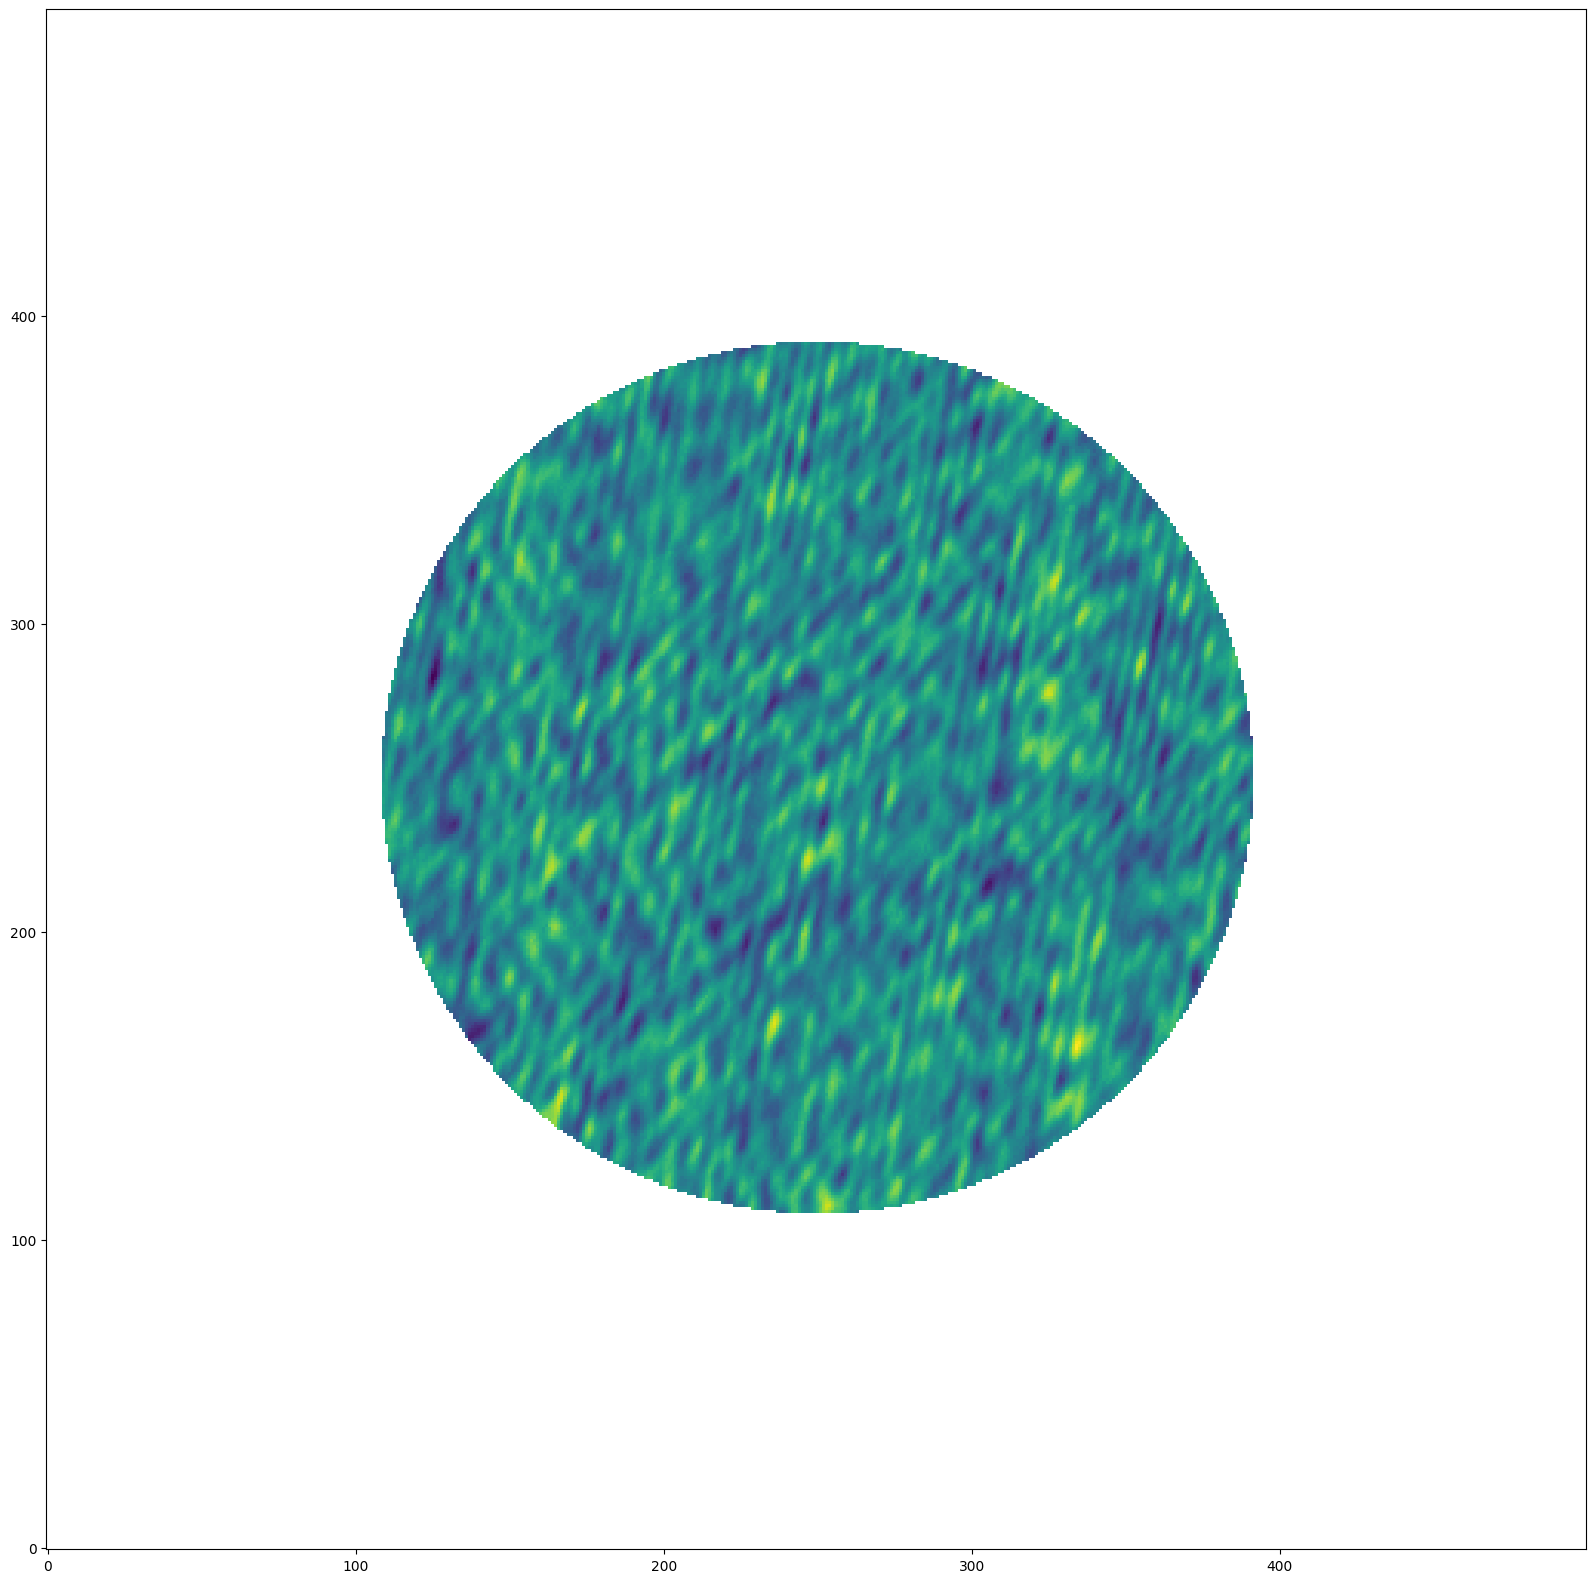

In [14]:
pl.figure(figsize=(20,20))
m0 = naclcube.spectral_slab(40*u.km/u.s, 76*u.km/u.s).moment0(axis=0)
m0.quicklook()

In [15]:
naclcube

DaskVaryingResolutionSpectralCube with shape=(1024, 500, 500) and unit=Jy / beam and chunk size (322, 322, 322):
 n_x:    500  type_x: RA---SIN  unit_x: deg    range:   266.794014 deg:  266.872811 deg
 n_y:    500  type_y: DEC--SIN  unit_y: deg    range:   -28.412494 deg:  -28.343189 deg
 n_s:   1024  type_s: VRAD      unit_s: km / s  range:     -124.576 km / s:     243.312 km / s

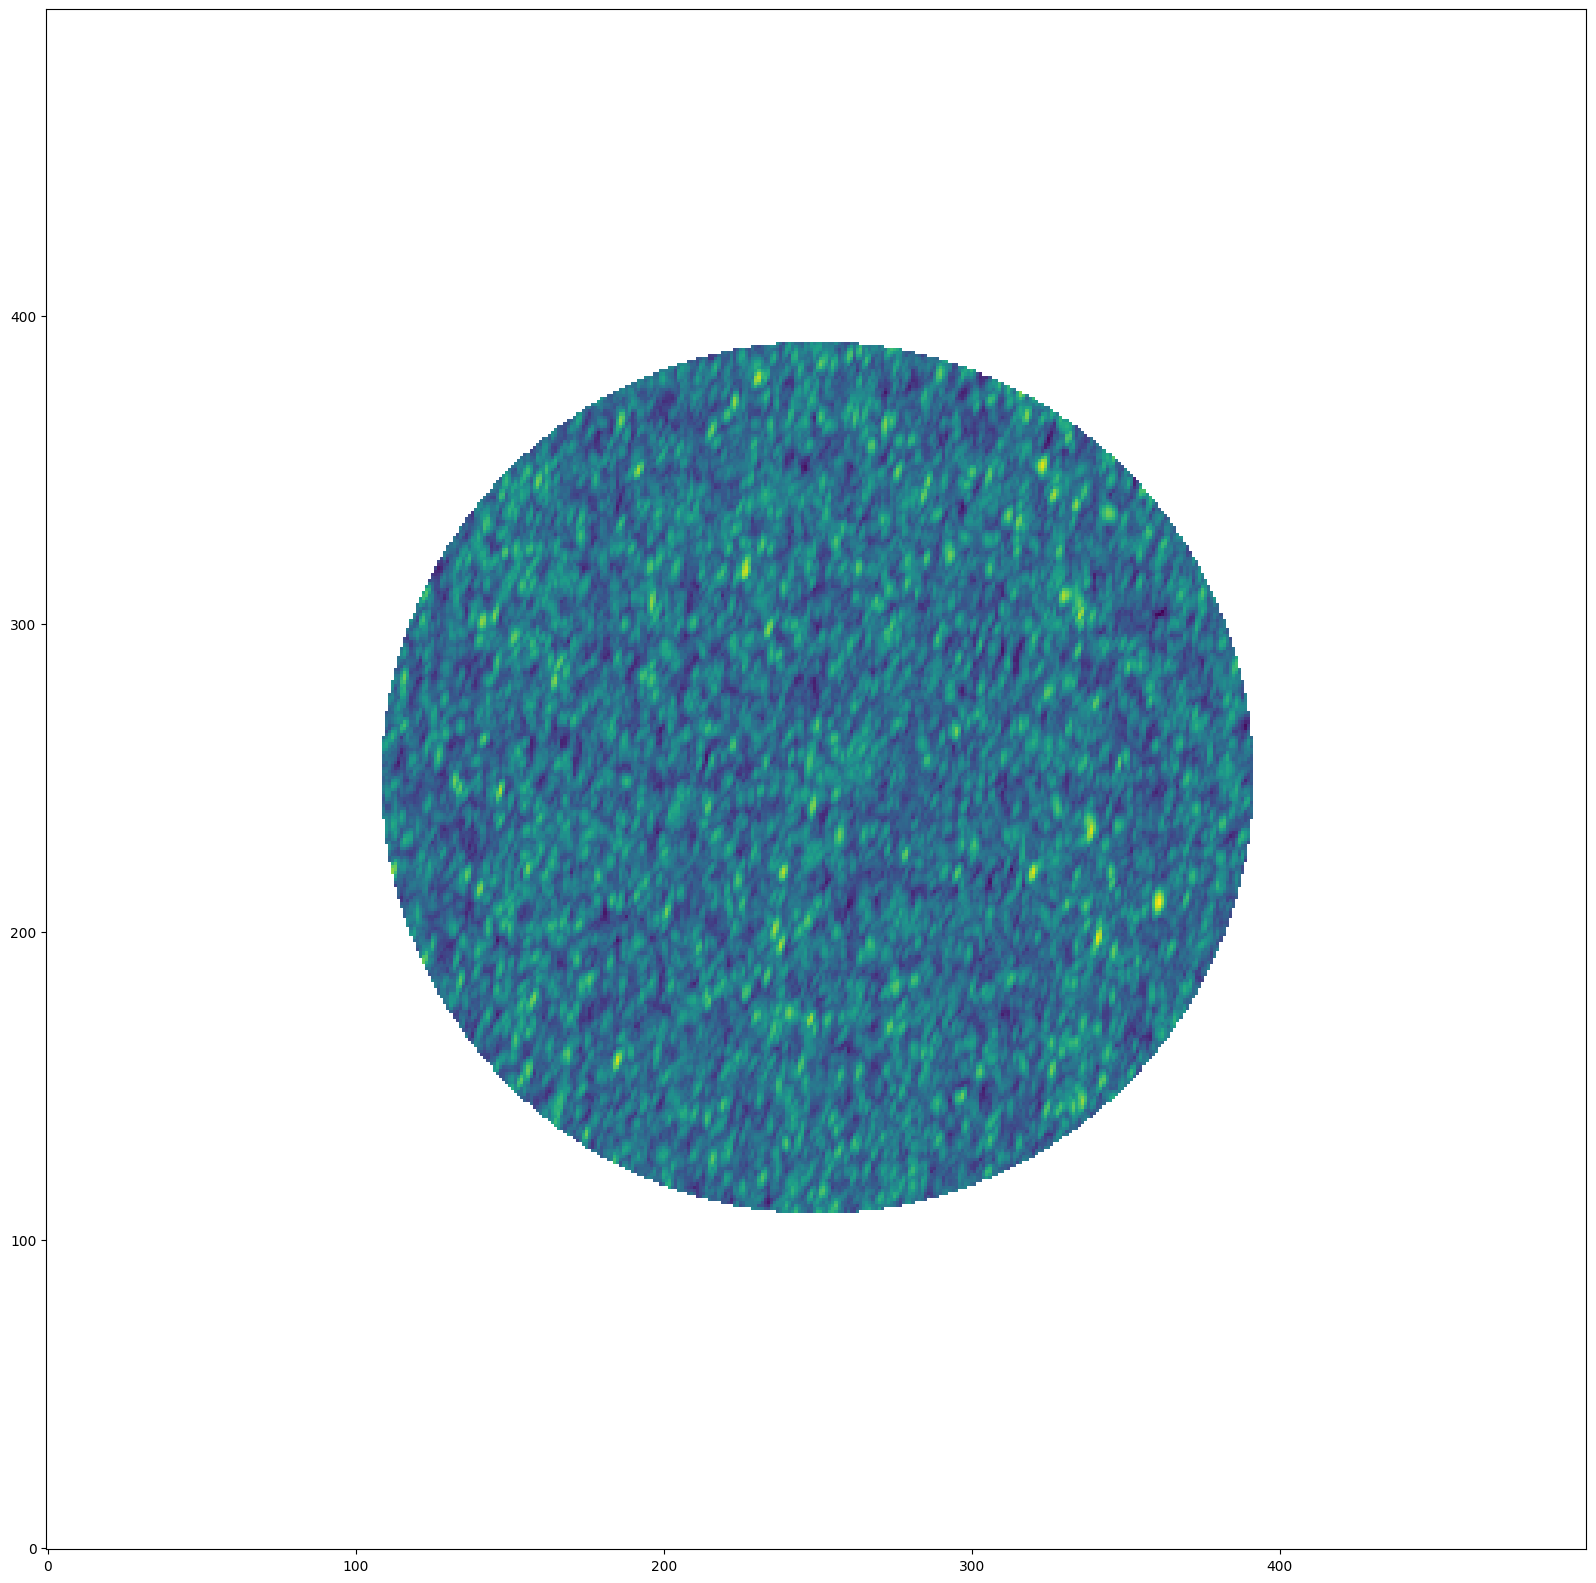

In [16]:
pl.figure(figsize=(20,20))
mx = naclcube.spectral_slab(40*u.km/u.s, 76*u.km/u.s).max(axis=0)
mx.quicklook()

In [17]:
import regions

In [18]:
hiiregions = regions.Regions.read("../regions_2018paper/SgrB2_1.3cm_hiiRegions_masked_Done.reg")
named_regions = {r.meta['text']: r for r in hiiregions if 'text' in r.meta}

In [19]:
targets = [('K1', 'K2', 'K3'), 'K4', 'Z10.24', 'I', 'E', 'B', 'G', ('F2', 'F1', 'F10.303', 'F3', 'F4')]

In [20]:
def getreg(tgt):
    if isinstance(tgt, tuple):
        reg = regions.Regions([named_regions[x] for x in tgt])
    else:
        reg = regions.Regions([named_regions[tgt]])                              
    return reg

In [21]:
fns = ['KbandDarray.center.robust0.spw13.big-coarse.liteclean.image',
      ]

In [22]:
cubes = [SpectralCube.read(fn, use_dask=True) for fn in fns]

/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [23]:
import warnings
warnings.filterwarnings('ignore')

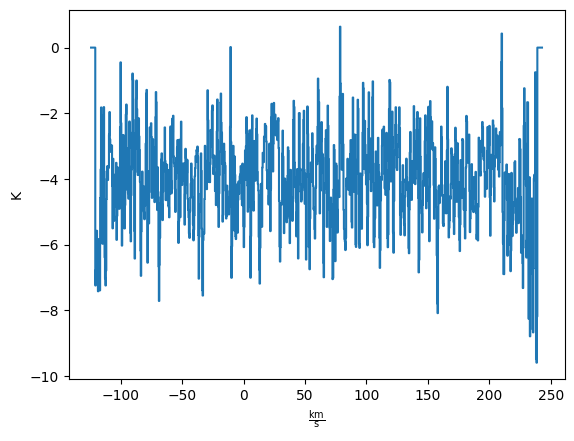

In [24]:
cube=cubes[0]
meanspec = cube.subcube_from_regions([named_regions['K1']]).with_spectral_unit(u.km/u.s, rest_value=nacl21rest, velocity_convention='radio').to(u.K).mean(axis=(1,2))
meanspec[1:-1].with_spectral_unit(u.km/u.s).quicklook()

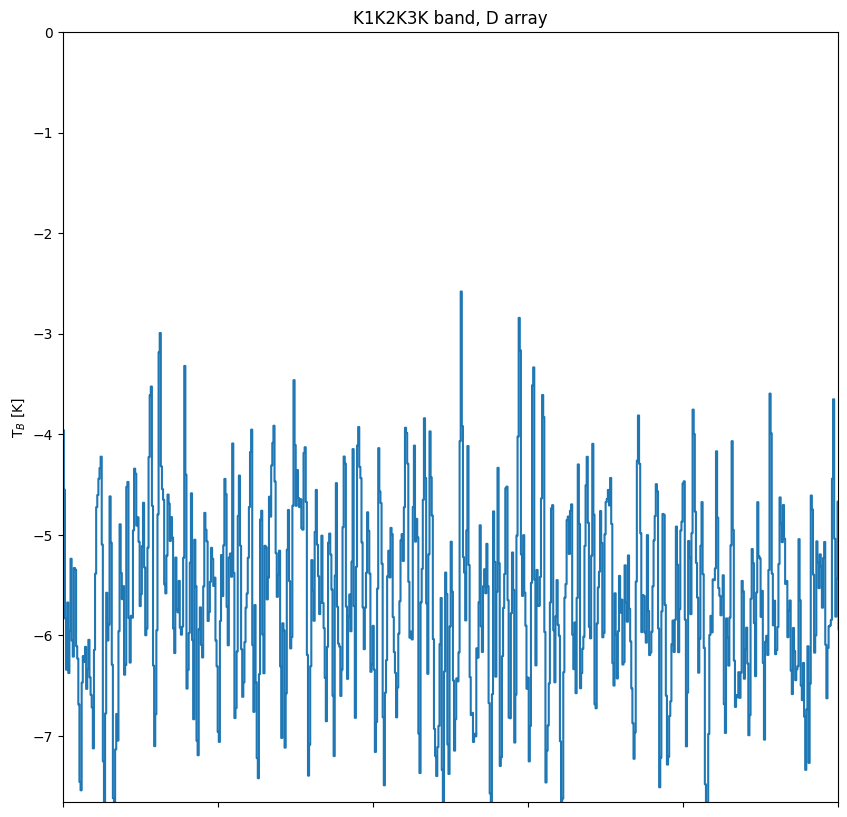

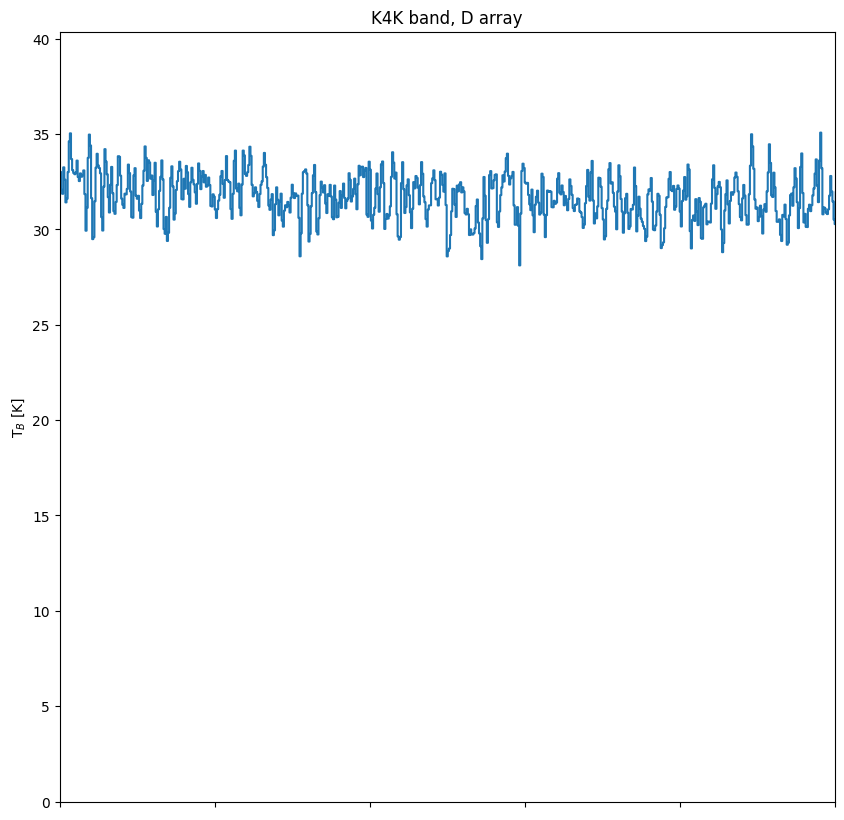

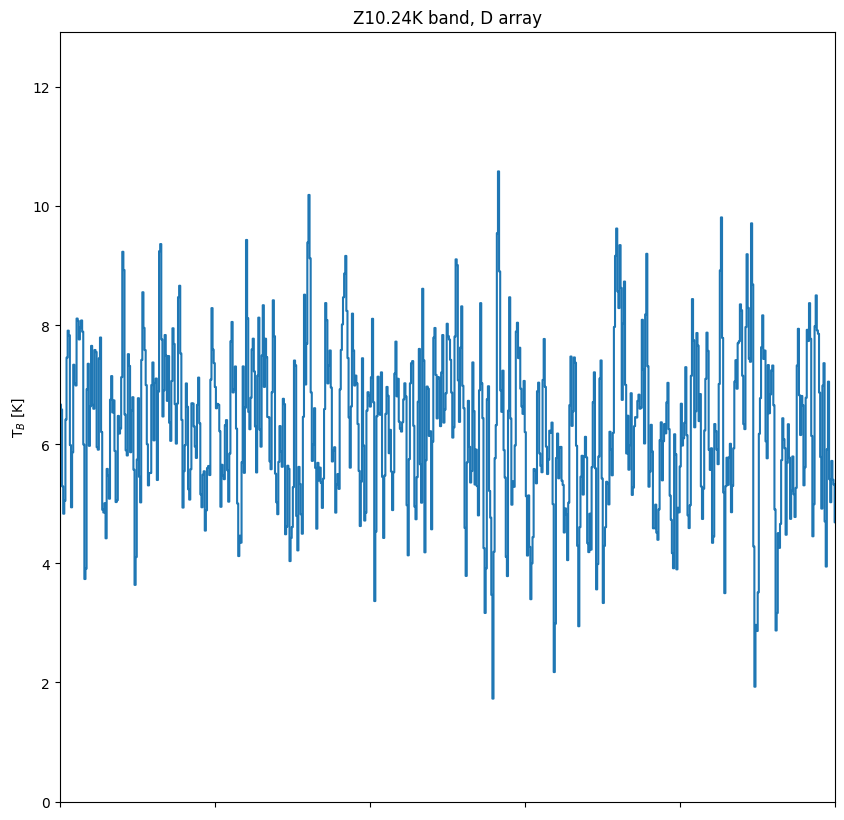

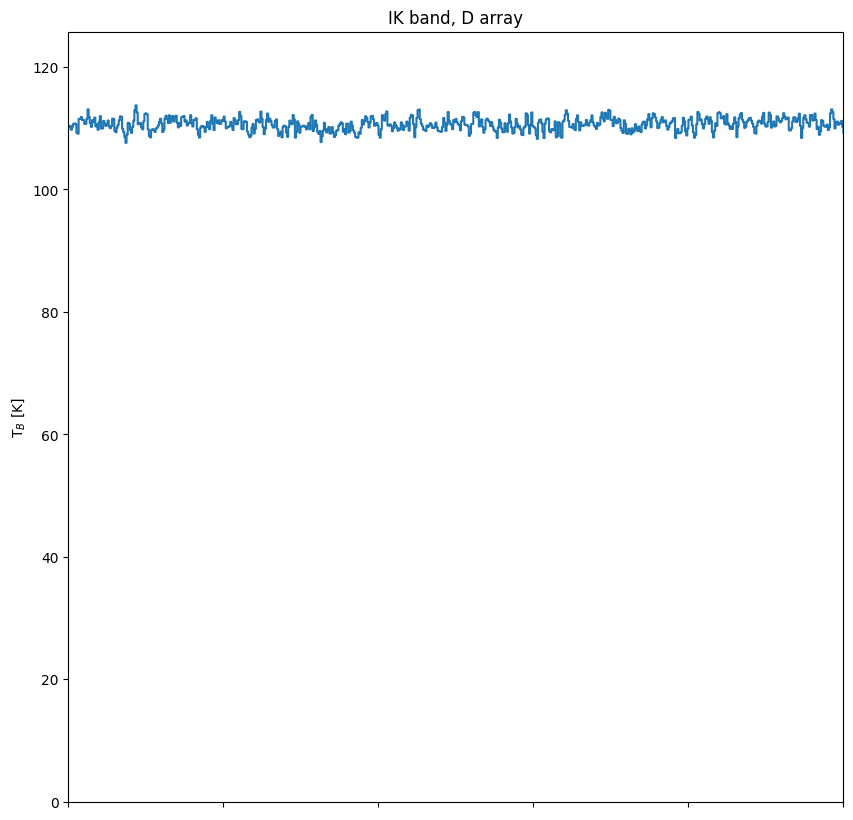

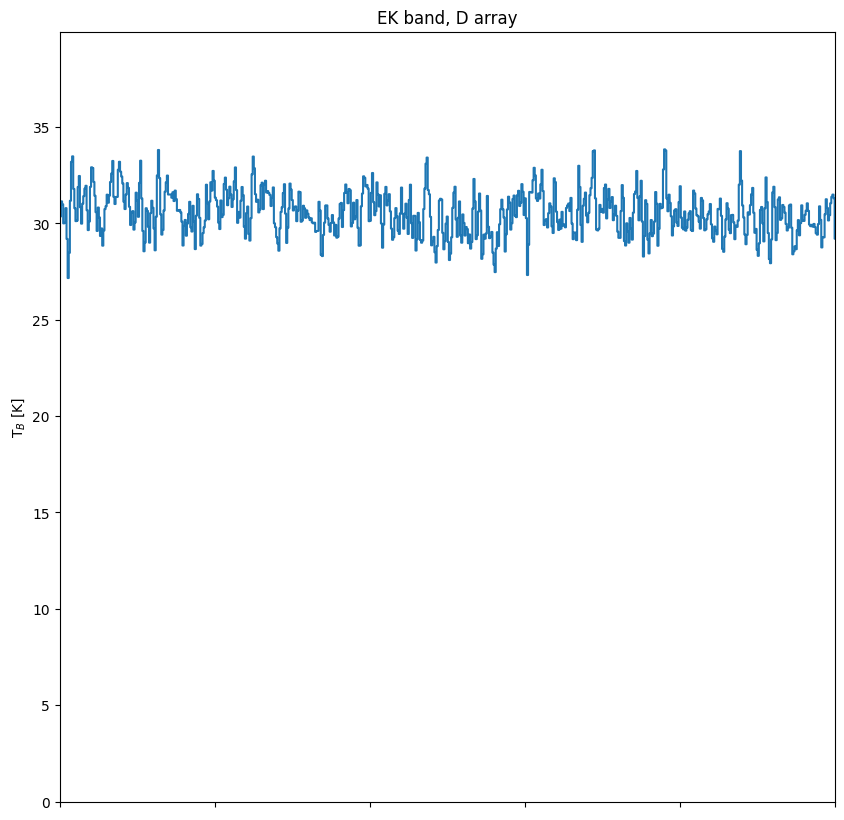

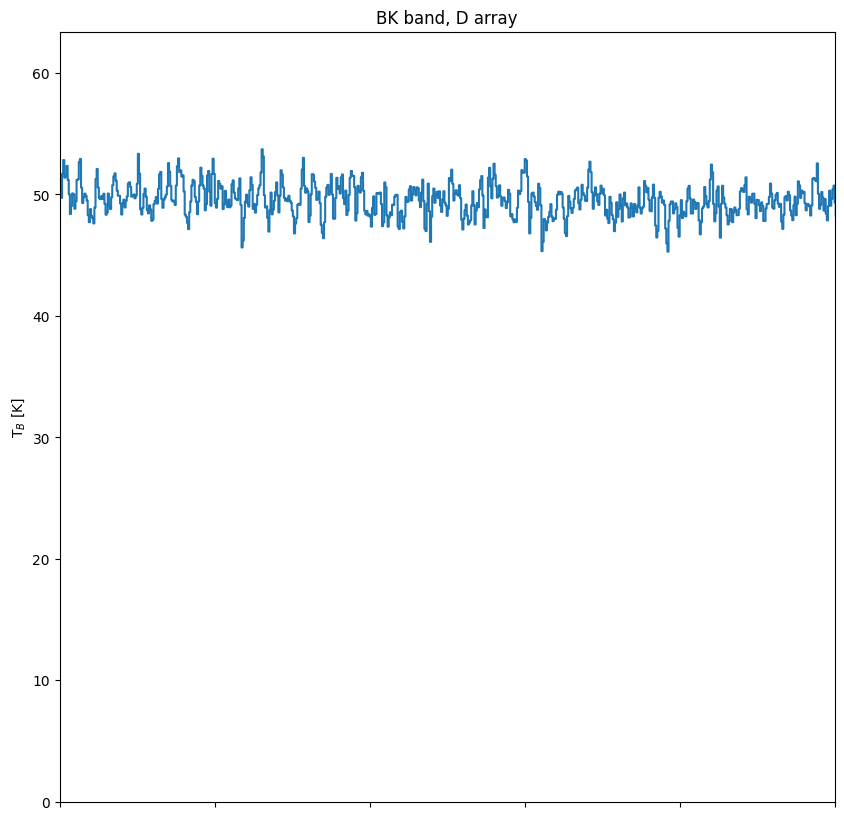

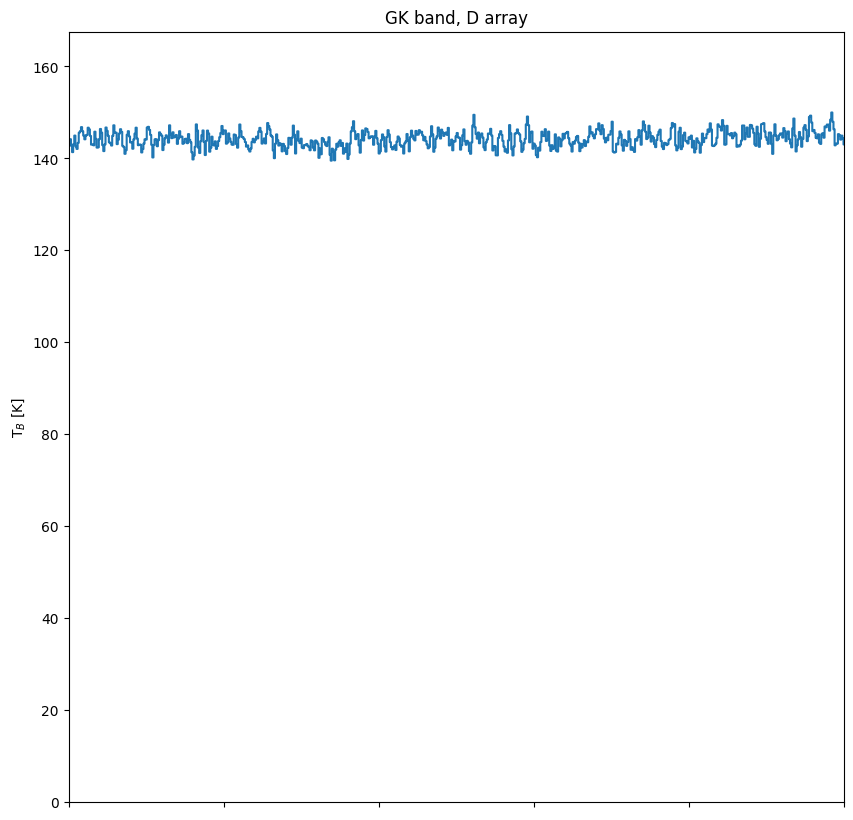

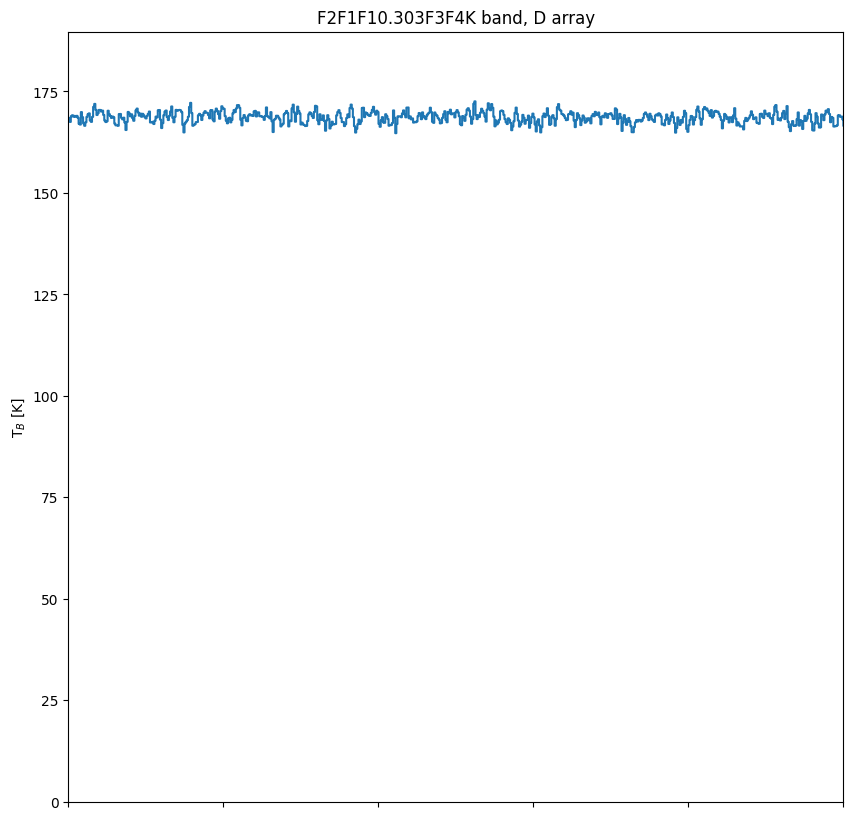

In [25]:
for tgt in targets:
    reg = getreg(tgt)
    name = "".join(tgt)
    fig = pl.figure(figsize=(10,10))
    for ii, cube in enumerate(cubes):
        ax = pl.subplot(1,1,1)
        try:
            meanspec = cube.subcube_from_regions(reg).with_spectral_unit(u.km/u.s, rest_value=nacl21rest, velocity_convention='radio').to(u.K).mean(axis=(1,2))
        except ValueError:
            continue
        if ii < 3:
            meanspec = meanspec[3:-3].with_spectral_unit(u.km/u.s) # chop out bad edge pixels
        ax.plot(meanspec.spectral_axis, meanspec.value, drawstyle='steps-mid')
        ax.set_xlim(-50, 200)
        #ax.set_ylim(np.percentile(meanspec.value, 1)*0.9, np.percentile(meanspec.value, 99.99)*1.1)
        if ii == 3:
            ax.set_xlabel("V$_{LSR}$ [km/s]")
        else:
            ax.set_xticklabels('')
            ax.set_xlabel("")
        ax.set_ylabel("T$_B$ [K]")
        if ii == 0:
            ax.set_title(name + "K band, D array")
    fig.savefig(f"../figures/{name}_KbandDarray_spectra.png")

In [26]:
pwd

'/orange/adamginsburg/sgrb2/22A-020/imaging_Darray'

In [27]:
from astropy.table import Table
from astropy import constants

In [28]:
from astropy.table import Table
primos = Table.read('../PRIMOS_spectrum.txt', format='ascii.no_header')
pfrq = (primos['col1'] * u.MHz * (1-64*u.km/u.s/constants.c)).to(u.GHz)
pamp = primos['col2'] * u.K

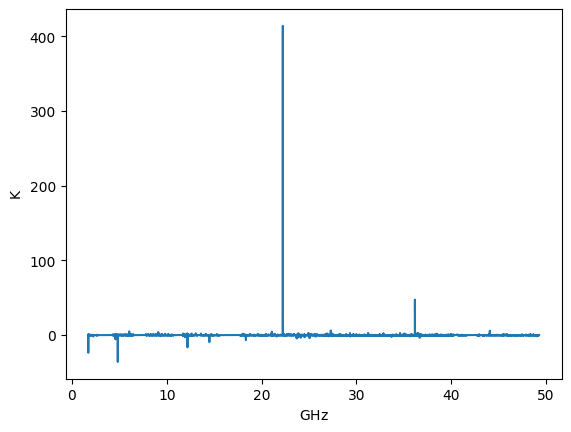

In [29]:
pl.plot(pfrq,pamp)

In [30]:
from astropy.coordinates import SkyCoord

In [31]:
primos_center = SkyCoord('17h47m19.8', '-28:22:17', unit=(u.h, u.deg), frame='fk5')

In [32]:
import glob
import regions
from astropy import wcs
from astropy.io import fits

In [33]:
mkdir -p primos_spectra/pngs

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
pfrq

<Quantity [ 1.7098067 ,  1.70983112,  1.70985553, ..., 49.25475573,
           49.25478015, 49.25480456] GHz>

In [36]:
from astroquery.splatalogue import Splatalogue

In [37]:
Splatalogue.query_lines(25.704*u.GHz, 25.714*u.GHz, chemical_name='Ammonia')

<Table length=2>
species_id                     name                    chemical_name        resolved_QNs       linelist LovasASTIntensity lower_state_energy upper_state_energy ... obsref_Lovas_NIST source_Lovas_NIST telescope_Lovas_NIST transitionBandColor searchErrorMessage sqlquery requestnumber
  int64                       str43                         str7               str25             str8          str1            float64            float64       ...        str1              str1               str1                str13               str1         object      int64    
---------- ------------------------------------------- ------------- ------------------------- -------- ----------------- ------------------ ------------------ ... ----------------- ----------------- -------------------- ------------------- ------------------ -------- -------------
       638 NH<sub>3</sub> <font color="red">v=0</font>       Ammonia  7(7 )0a- 7(7 )0s, F=6 -7 TopModel                             374.2301          375.08778 ...                                                                datatablegrey                        None             0
       638 NH<sub>3</sub> <font color="red">v=0</font>       Ammonia  7(7 )0a- 7(7 )0s, F=8 -7 TopModel                             374.2301          375.08779 ...                                                                datatablegrey                        None             0

In [38]:
Splatalogue.query_lines(22.914*u.GHz, 22.926*u.GHz, chemical_name='Ammonia')

<Table length=11>
species_id                     name                    chemical_name                   resolved_QNs                  linelist LovasASTIntensity lower_state_energy ... obsref_Lovas_NIST source_Lovas_NIST telescope_Lovas_NIST transitionBandColor searchErrorMessage sqlquery requestnumber
  int64                       str43                         str7                          str47                        str8          str4            float64       ...        str5              str8              str13                str13               str1         object      int64    
---------- ------------------------------------------- ------------- ----------------------------------------------- -------- ----------------- ------------------ ... ----------------- ----------------- -------------------- ------------------- ------------------ -------- -------------
       638 NH<sub>3</sub> <font color="red">v=0</font>       Ammonia                        7(6 )0a- 7(6 )0s, F=6 -7 TopModel                             422.4749 ...                                                                datatablegrey                        None             0
       638 NH<sub>3</sub> <font color="red">v=0</font>       Ammonia                        7(6 )0a- 7(6 )0s, F=8 -7 TopModel                             422.4749 ...                                                                datatablegrey                        None             0
       638 NH<sub>3</sub> <font color="red">v=0</font>       Ammonia 7(6)<sup>-</sup> - 7(-6)<sup>+</sup>, F = 6 - 7     CDMS                             421.6649 ...                                                                datatablegrey                        None             0
       638 NH<sub>3</sub> <font color="red">v=0</font>       Ammonia 7(6)<sup>-</sup> - 7(-6)<sup>+</sup>, F = 7 - 7     CDMS                             421.6649 ...                                                                datatablegrey                        None             0
       638 NH<sub>3</sub> <font color="red">v=0</font>       Ammonia 7(6)<sup>-</sup> - 7(-6)<sup>+</sup>, F = 6 - 6     CDMS                             421.6648 ...                                                                datatablegrey                        None             0
       638 NH<sub>3</sub> <font color="red">v=0</font>       Ammonia                        7(6 )0a- 7(6 )0s, F=7 -7 TopModel                             422.4749 ...                                                                datatablegrey                        None             0
       638 NH<sub>3</sub> <font color="red">v=0</font>       Ammonia                        7(6 )0a- 7(6 )0s, F=6 -6 TopModel                             422.4749 ...                                                                datatablegrey                        None             0
       638 NH<sub>3</sub> <font color="red">v=0</font>       Ammonia                        7(6 )0a- 7(6 )0s, F=8 -8 TopModel                             422.4749 ...                                                                datatablegrey                        None             0
       638 NH<sub>3</sub> <font color="red">v=0</font>       Ammonia                                7( 6)0a- 7(-6)0s      JPL                             421.6649 ...                                                                datatablegrey                        None             0
       638 NH<sub>3</sub> <font color="red">v=0</font>       Ammonia                                7( 6)0a- 7( 6)0s    Lovas               1.0                0.0 ...             Nys78           OriMC-1         MPI     100m       datatablegrey                        None             0
       638 NH<sub>3</sub> <font color="red">v=0</font>       Ammonia                           7(  6)0a -   7( -6)0s    SLAIM               1.0            422.471 ...                                                                datatablegrey                     

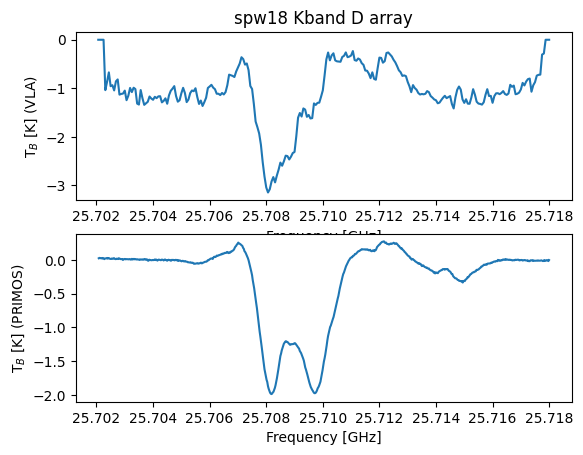

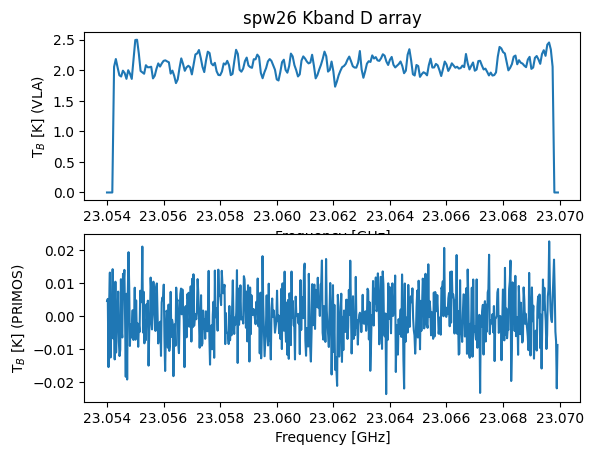

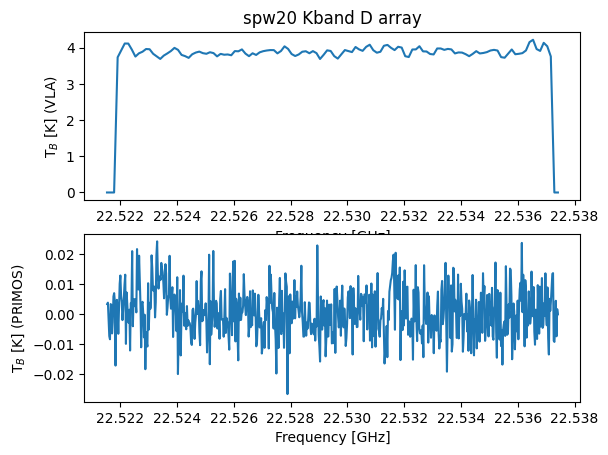

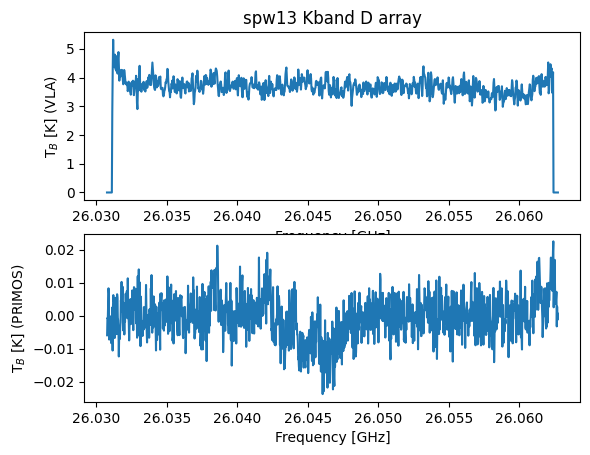

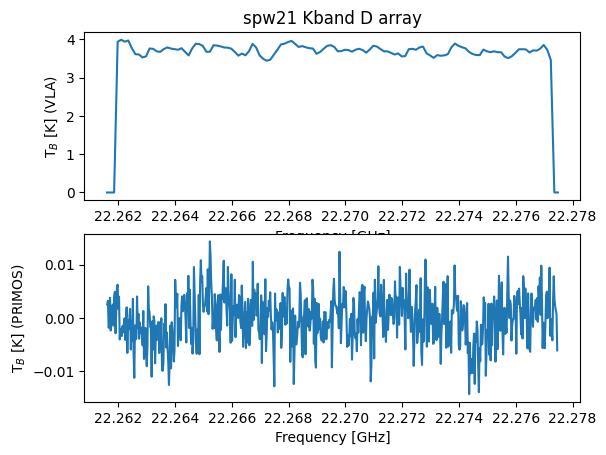

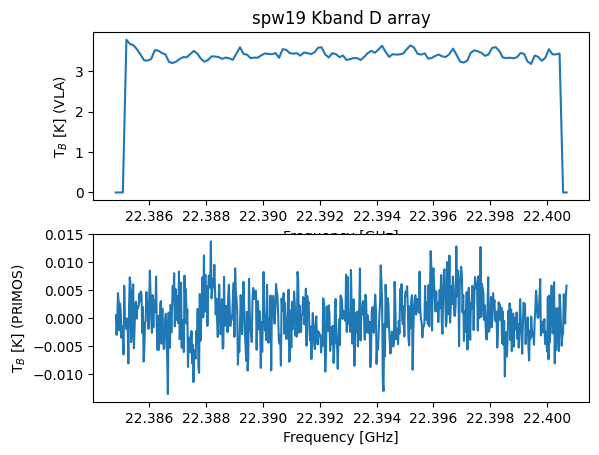

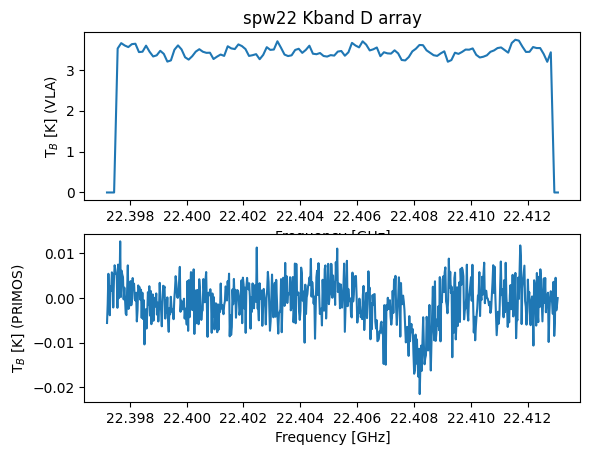

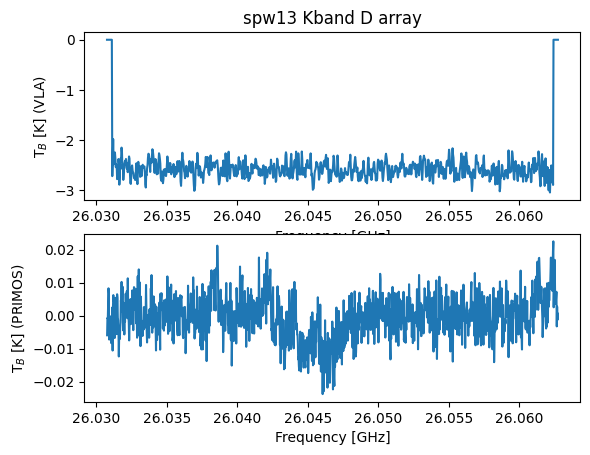

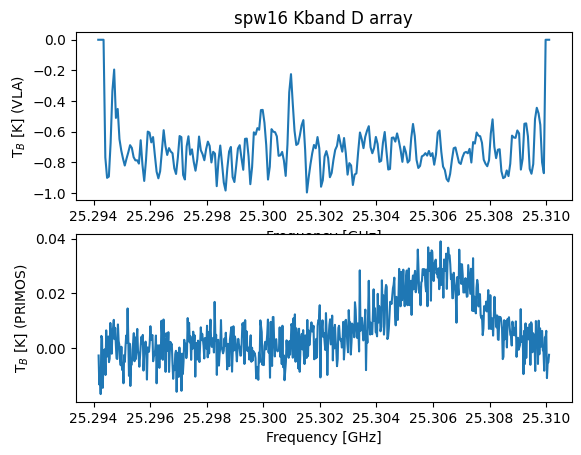

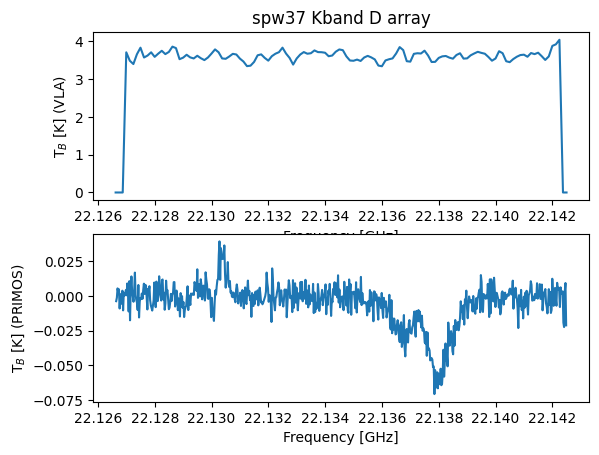

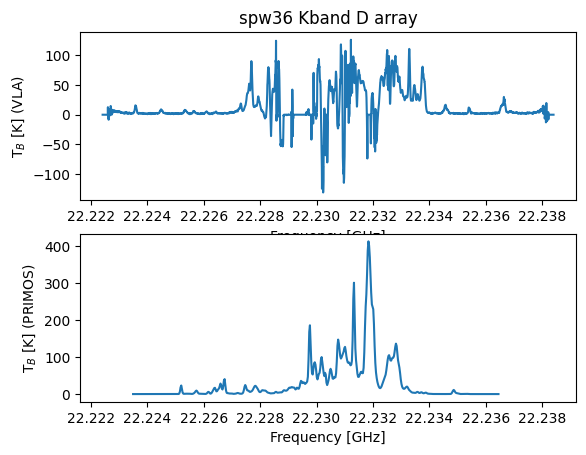

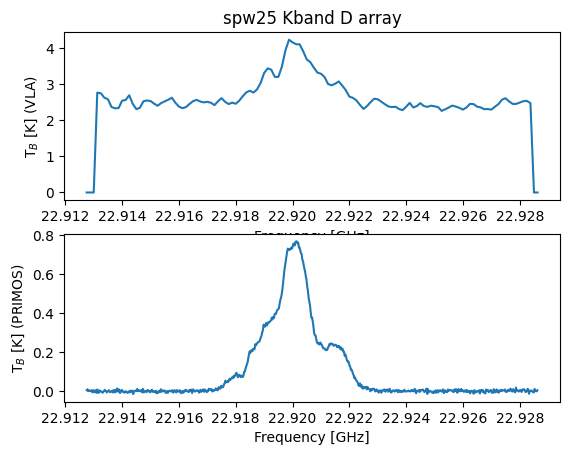

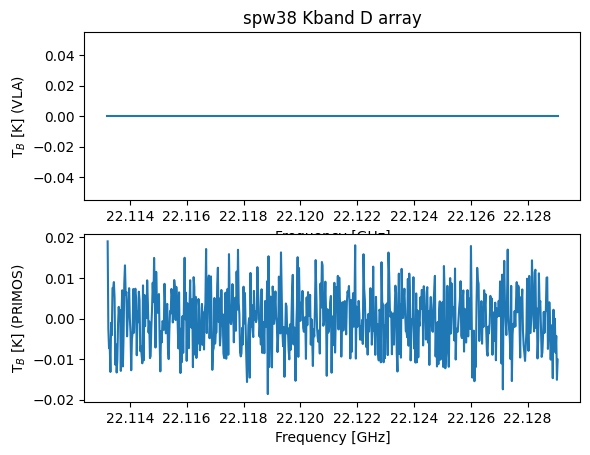

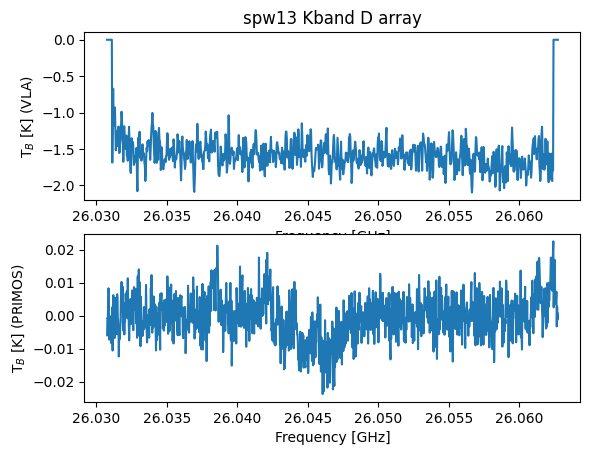

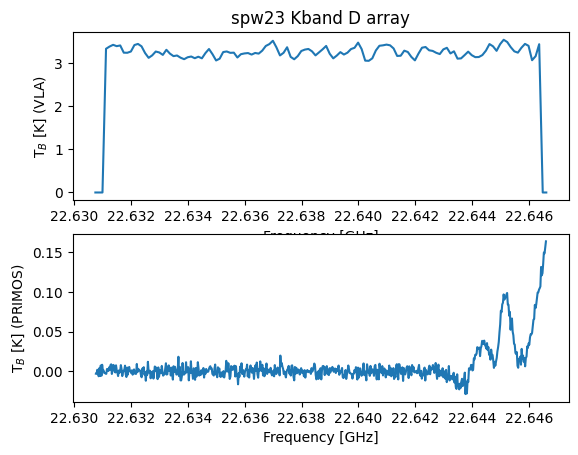

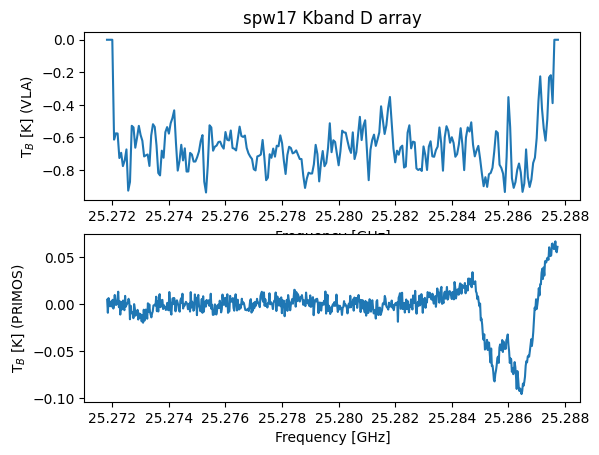

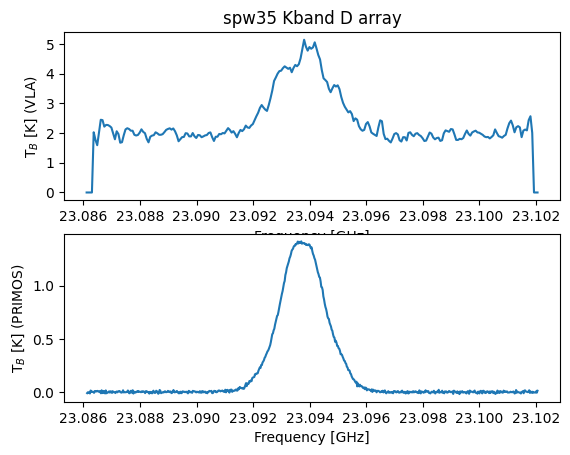

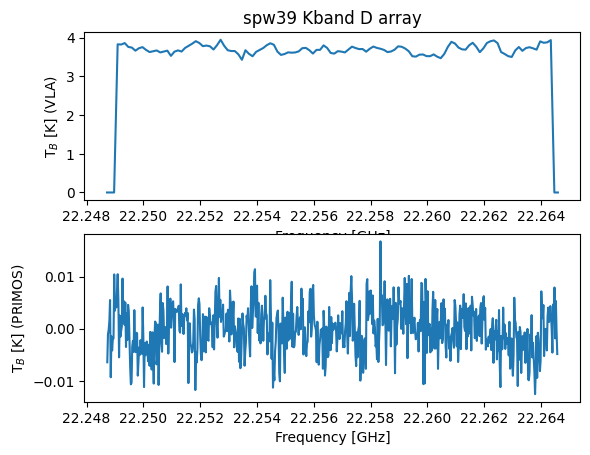

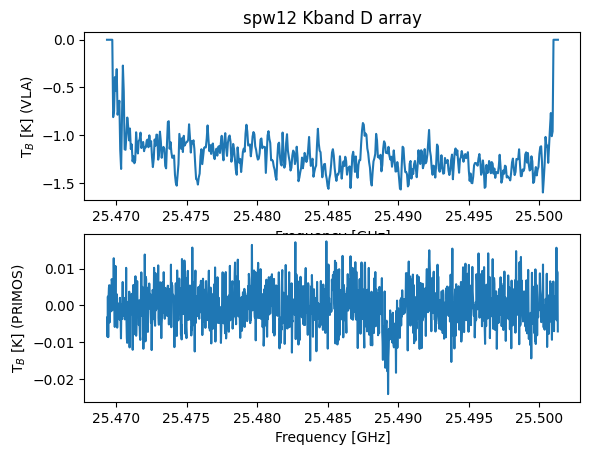

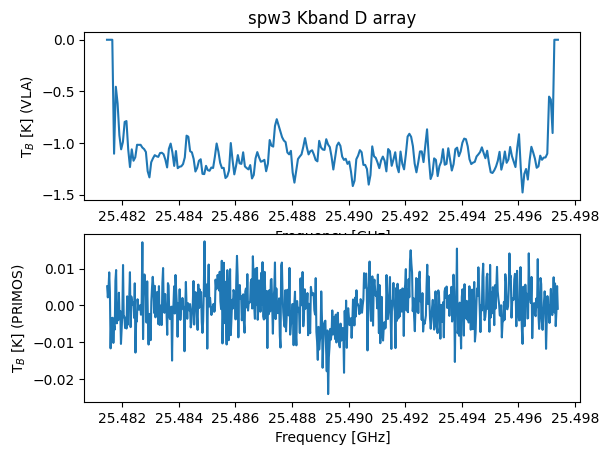

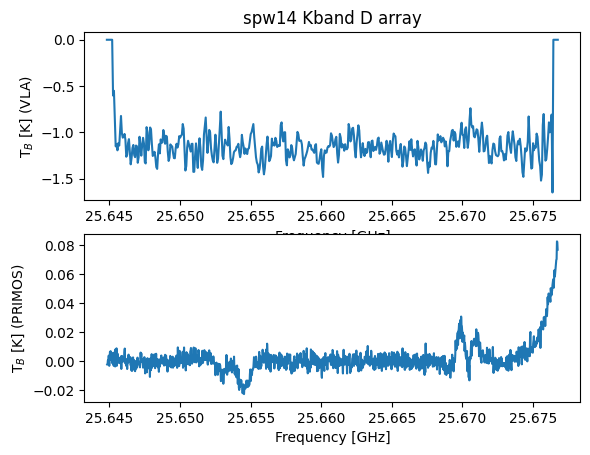

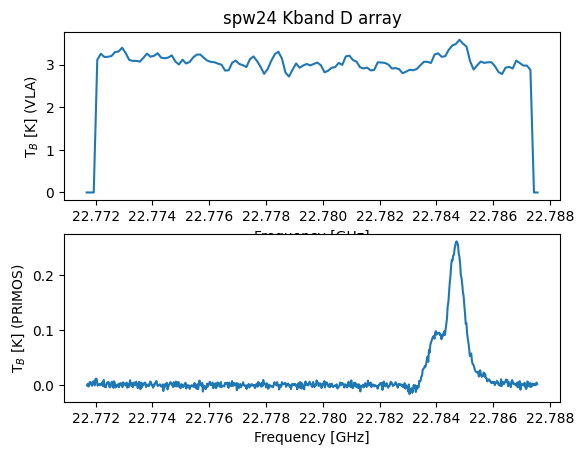

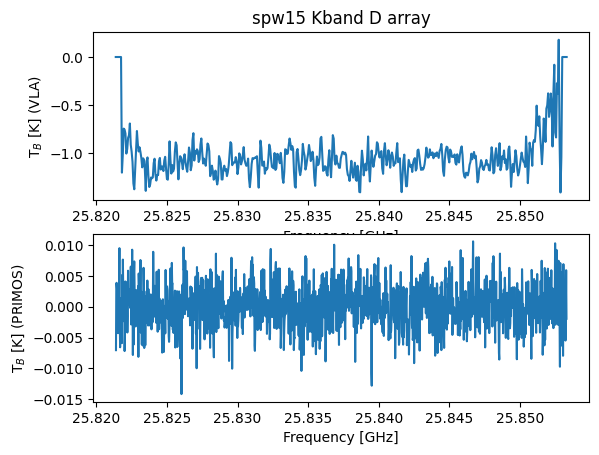

In [39]:
for fn in glob.glob("Kband*.image"):
    if 'continuum' in fn:
        continue
    specfn = f'primos_spectra/{fn}.meanspec.fits'
    if not os.path.exists(specfn):
        cube = SpectralCube.read(fn, use_dask=True).with_spectral_unit(u.GHz)
        # estimate of GBT beam
        primos_fwhm = (cube.spectral_axis.mean().to(u.m, u.spectral()) / (100*u.m)).to(u.arcsec, u.dimensionless_angles())
        aperture = regions.CircleSkyRegion(center=primos_center, radius=primos_fwhm/2)
        try:
            subcube = cube.subcube_from_regions([aperture])
        except ValueError as ex:
            continue
        meanspec = subcube.mean(axis=(1,2)).to(u.K)
        hdu = meanspec.hdu
        hdu.writeto(specfn)
        xax = meanspec.spectral_axis.to(u.GHz)
        yax = meanspec.value
    else:
        hdu = fits.open(specfn)[0]
        yax = hdu.data
        xax = wcs.WCS(hdu.header).pixel_to_world(np.arange(len(yax))).to(u.GHz)
    
    fig = pl.figure()
    ax = fig.add_subplot(2,1,1)
    ax.plot(xax, yax)
    ax.set_xlabel("Frequency [GHz]")
    ax.set_ylabel("T$_B$ [K] (VLA)")
    
    try:
        spw = [x for x in fn.split(".") if 'spw' in x][0]
        ax.set_title(spw + " Kband D array")
    except:
        ax.set_title(fn)
    
    # make sure we're in GHz units
    assert xax.max() < 50*u.GHz
    assert pfrq.unit == u.GHz
    assert xax.unit == u.GHz
    
    sel = (pfrq > xax.min()) & (pfrq < xax.max())
    assert sel.sum() > 0
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(pfrq[sel], pamp[sel])
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xlabel("Frequency [GHz]")
    ax2.set_ylabel("T$_B$ [K] (PRIMOS)")
    
    fig.savefig(f'primos_spectra/pngs/{fn}.meanspec.png', bbox_inches='tight')

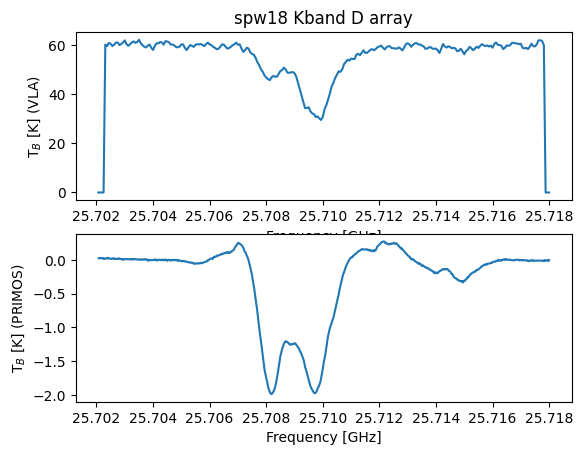

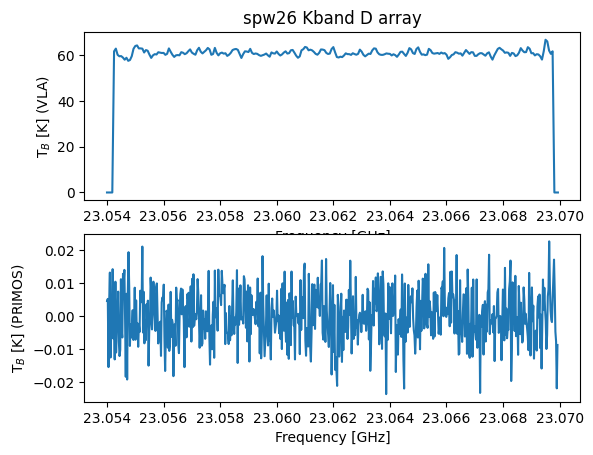

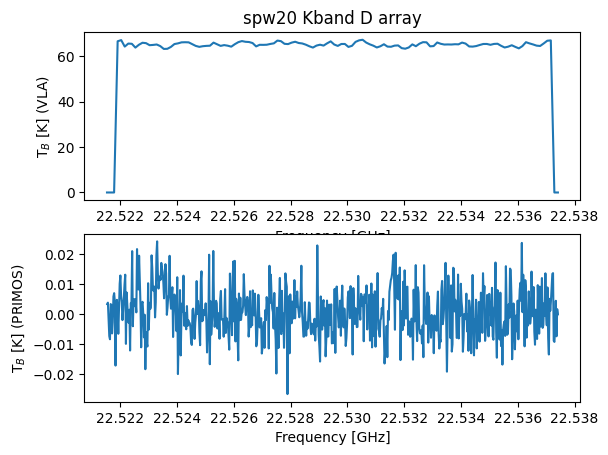

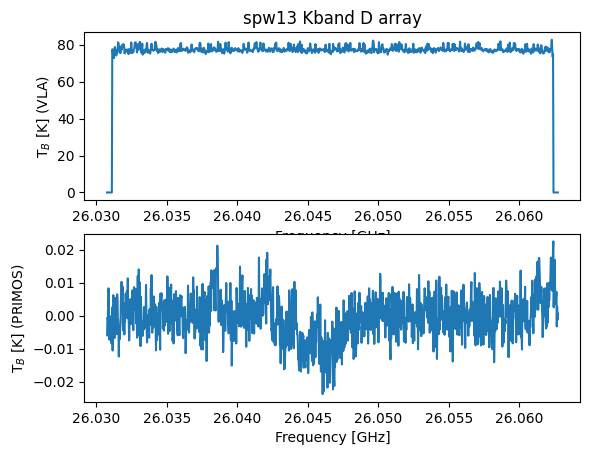

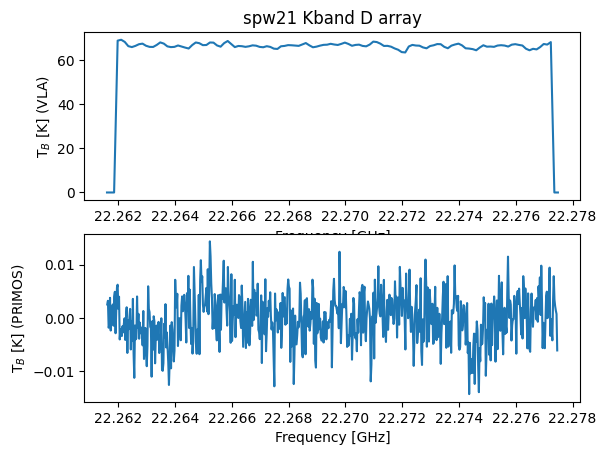

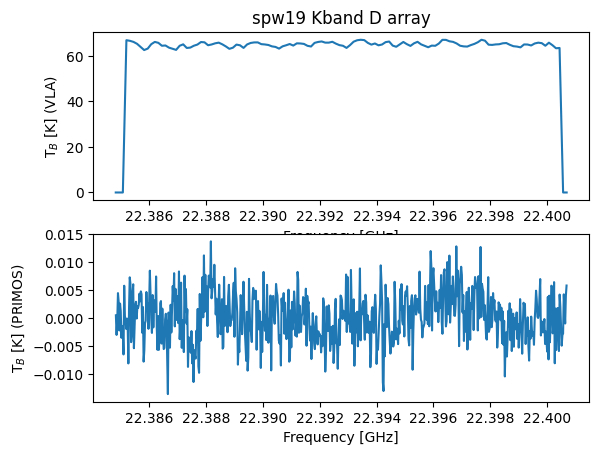

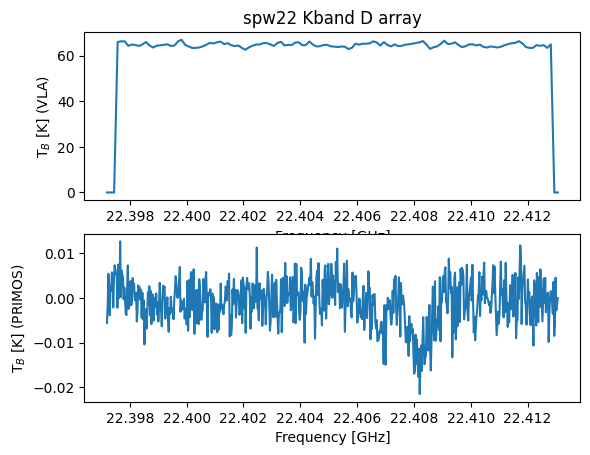

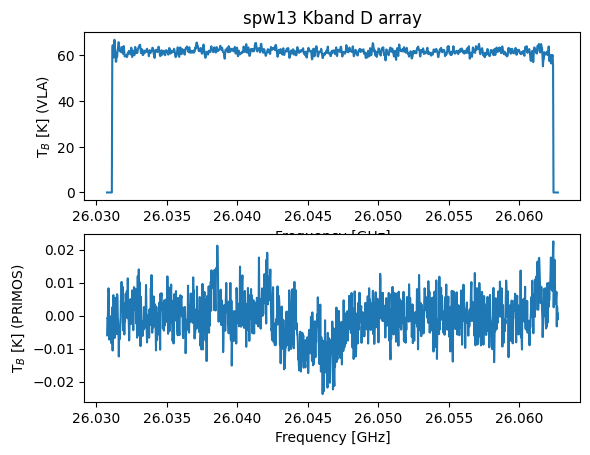

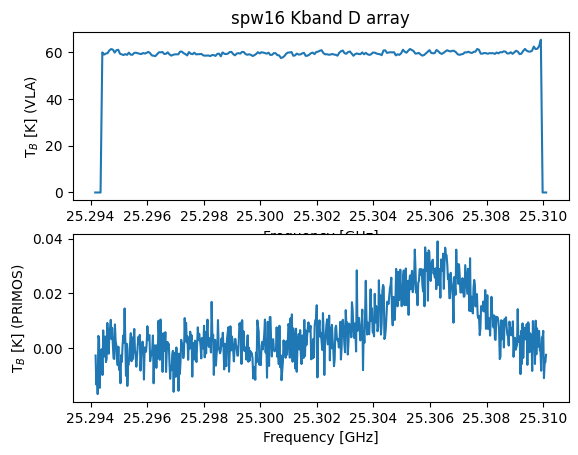

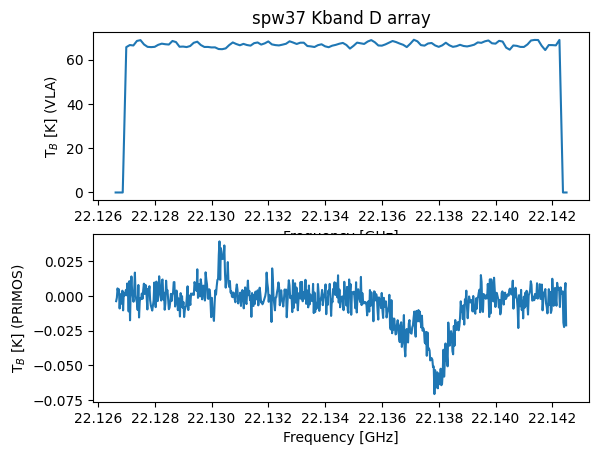

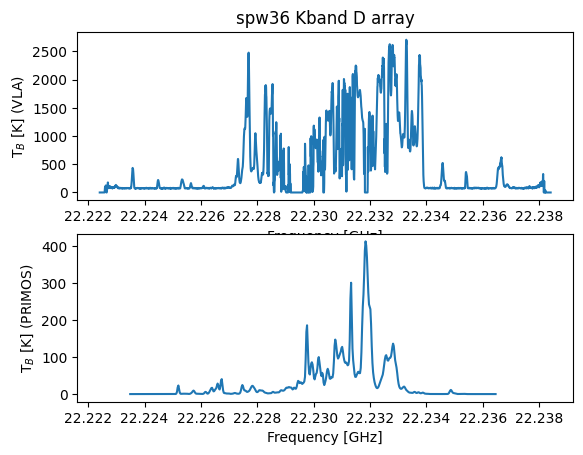

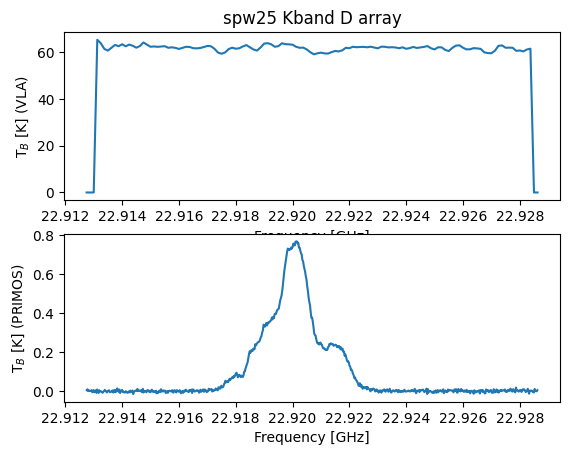

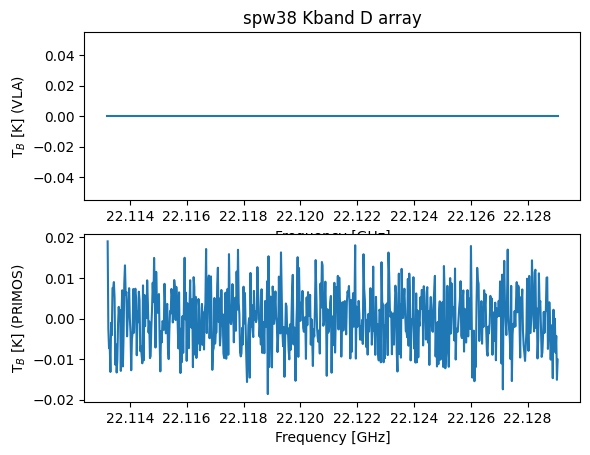

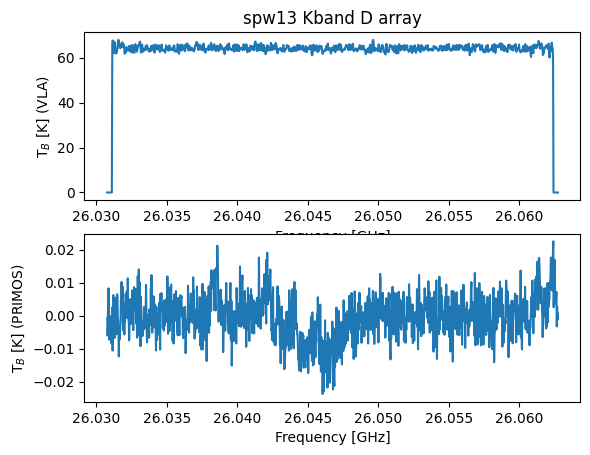

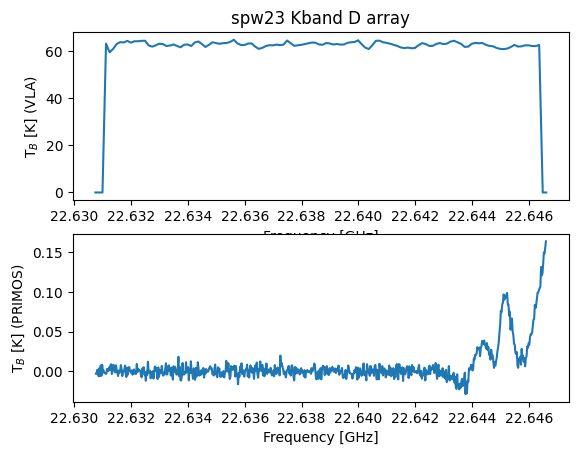

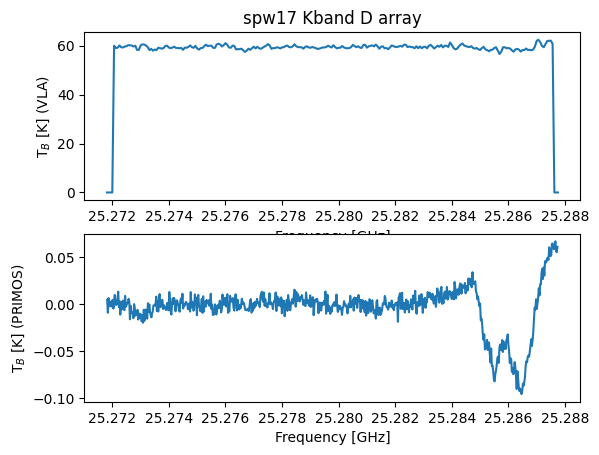

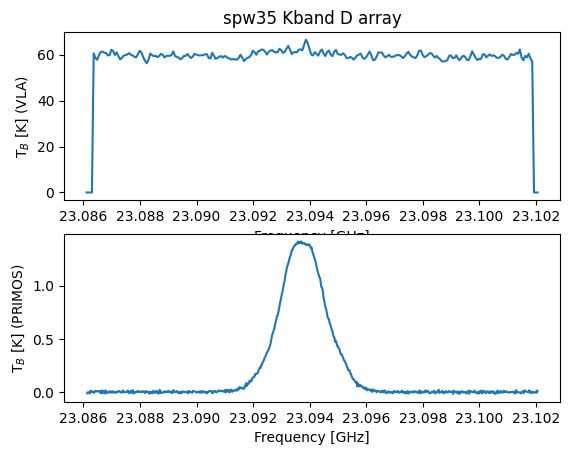

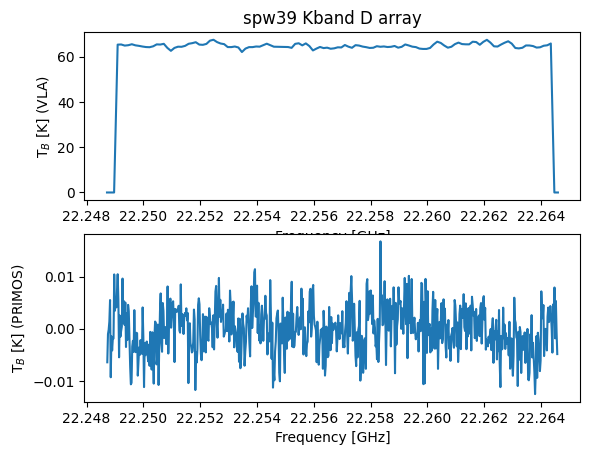

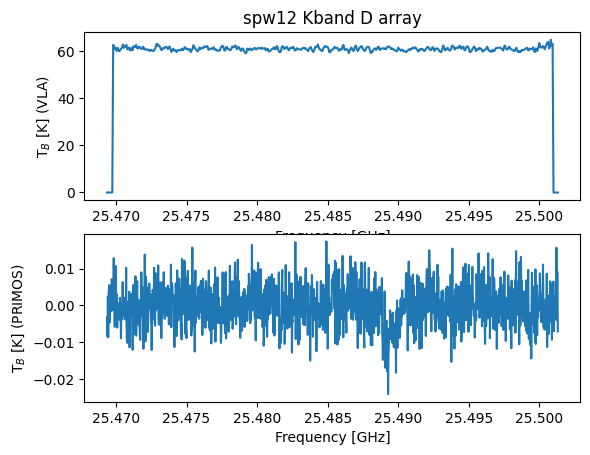

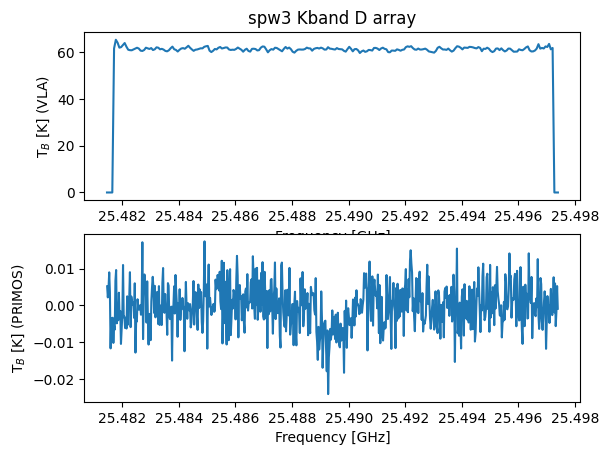

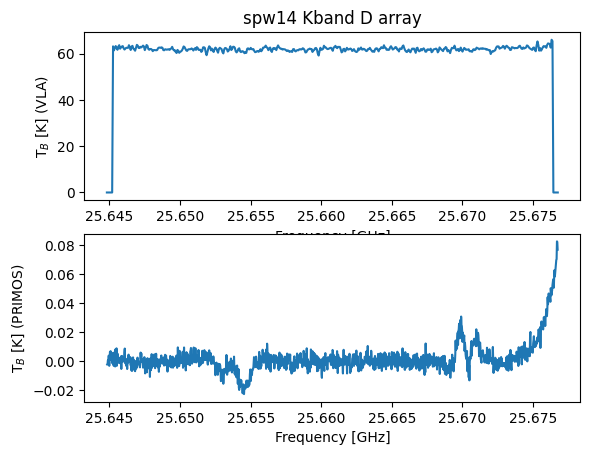

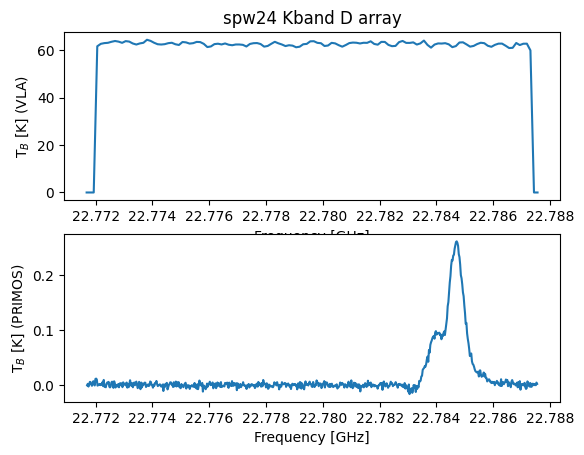

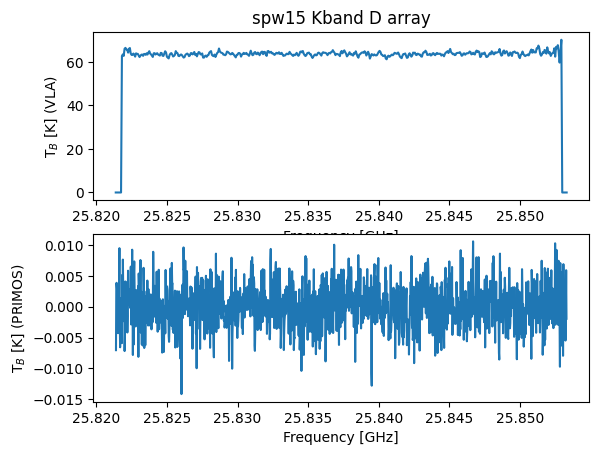

In [40]:
for fn in glob.glob("Kband*.image"):
    if 'continuum' in fn:
        continue
    specfn = f'primos_spectra/{fn}.maxspec.fits'
    if not os.path.exists(specfn):
        cube = SpectralCube.read(fn, use_dask=True).with_spectral_unit(u.GHz)
        # estimate of GBT beam
        primos_fwhm = (cube.spectral_axis.mean().to(u.m, u.spectral()) / (100*u.m)).to(u.arcsec, u.dimensionless_angles())
        aperture = regions.CircleSkyRegion(center=primos_center, radius=primos_fwhm/2)
        try:
            subcube = cube.subcube_from_regions([aperture])
        except ValueError as ex:
            continue
        maxspec = subcube.max(axis=(1,2)).to(u.K)
        hdu = maxspec.hdu
        hdu.writeto(specfn)
        xax = maxspec.spectral_axis.to(u.GHz)
        yax = maxspec.value
    else:
        hdu = fits.open(specfn)[0]
        yax = hdu.data
        xax = wcs.WCS(hdu.header).pixel_to_world(np.arange(len(yax))).to(u.GHz)
    
    fig = pl.figure()
    ax = fig.add_subplot(2,1,1)
    ax.plot(xax, yax)
    ax.set_xlabel("Frequency [GHz]")
    ax.set_ylabel("T$_B$ [K] (VLA)")
    
    spw = [x for x in fn.split(".") if 'spw' in x][0]
    ax.set_title(spw + " Kband D array")
    
    # make sure we're in GHz units
    assert xax.max() < 50*u.GHz
    assert pfrq.unit == u.GHz
    assert xax.unit == u.GHz
    
    sel = (pfrq > xax.min()) & (pfrq < xax.max())
    assert sel.sum() > 0
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(pfrq[sel], pamp[sel])
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xlabel("Frequency [GHz]")
    ax2.set_ylabel("T$_B$ [K] (PRIMOS)")
    
    fig.savefig(f'primos_spectra/pngs/{fn}.maxspec.png', bbox_inches='tight')